In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from tqdm.auto import trange # 用于进度条

# 设置 matplotlib 字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

# 设置随机种子以便复现
torch.manual_seed(42)
np.random.seed(42)

# ----------------------------
# Config
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 物理参数 (来自 Problem 2)
L_DOMAIN = 0.01        # 半壁厚度 (m)
K_CONDUCTIVITY = 30.0  # 导热系数 (W/m·K)
ALPHA = 5.0e-6         # 热扩散率 (m²/s)
H_CONVECTION = 1100.0  # 对流换热系数 (W/m²·K)
T_INF = 250.0          # 环境温度 (°C)
Q1_GEN = 1.0e7         # 初始热源 (W/m³)
Q2_GEN = 2.0e7         # 新热源 (W/m³)
T_FINAL = 1.5          # 模拟总时长 (s)

# PINN 超参数 (来自 Problem 2B)
N_F = 2000             # 内部采样点 (N_f >= 2000)
N_B = 500              # 边界/初始点 (Nb >= 150, 我们用500个点)
LAYERS = 5             # 4 个隐藏层 + 1 个输出层
NEURONS = 64           # 每层神经元
ACTIVATION = nn.Tanh   # 激活函数

# 训练参数
LR = 1e-3
EPOCHS = 20000         # 瞬态问题通常需要更多次迭代

# ---------------------------------
# 初始条件 (IC) T(x, 0) 的解析解
# (来自稳态, q1)
# ---------------------------------
# 1. 计算初始表面温度 (Ts)
T_s_initial = T_INF + (Q1_GEN * L_DOMAIN) / H_CONVECTION
# 2. 计算初始中心温度 (Tc)
T_c_initial = T_s_initial + (Q1_GEN * L_DOMAIN**2) / (2 * K_CONDUCTIVITY)
# 3. 定义 T(x, 0) 的 PyTorch 函数
def get_initial_T(x, Tc, q_gen, k_val):
    return Tc - (q_gen / (2.0 * k_val)) * x**2

print(f"--- 配置信息 (Problem 2) ---")
print(f"设备: {DEVICE}")
print(f"域尺寸 L: {L_DOMAIN} m, T: {T_FINAL} s")
print(f"N_f (内部点): {N_F}")
print(f"N_b (边界/初始点): {N_B}")
print(f"网络结构: {LAYERS-1} hidden layers, {NEURONS} neurons/layer")
print(f"初始中心温度 (T_c @ t=0): {T_c_initial:.2f} °C")
print(f"初始表面温度 (T_s @ t=0): {T_s_initial:.2f} °C")
print("------------------")

--- 配置信息 (Problem 2) ---
设备: cuda
域尺寸 L: 0.01 m, T: 1.5 s
N_f (内部点): 2000
N_b (边界/初始点): 500
网络结构: 4 hidden layers, 64 neurons/layer
初始中心温度 (T_c @ t=0): 357.58 °C
初始表面温度 (T_s @ t=0): 340.91 °C
------------------


In [2]:
def xavier_init(m):
    """Xavier 初始化权重"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

def grad(y, x):
    """计算 dy/dx，使用 autograd"""
    return torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y),
        create_graph=True, retain_graph=True
    )[0]

In [3]:
class MLP(nn.Module):
    """
    多层感知机 (MLP) - 全软约束版本
    输入: (x, t) -> 输出: T(x, t)
    """
    def __init__(self, in_dim=2, width=NEURONS, depth=LAYERS, out_dim=1, act=ACTIVATION):
        super().__init__()
        layers = [nn.Linear(in_dim, width), act()]
        # 4 个隐藏层
        for _ in range(depth - 2):
            layers += [nn.Linear(width, width), act()]
        # 输出层
        layers += [nn.Linear(width, out_dim)]
        
        self.net = nn.Sequential(*layers)
        self.net.apply(xavier_init) # 应用 Xavier 初始化

    def forward(self, xt):
        """
        前向传播 - 直接输出温度
        """
        return self.net(xt)

# 实例化模型和优化器
model = MLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("PINN 模型 (全软约束 - 时空域):")
print(model)

PINN 模型 (全软约束 - 时空域):
MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [4]:
print(f"正在生成 {N_F} 个内部点和 {N_B} 个边界/初始点...")

# 我们将 Nb=500 分配为:
N_IC = 200  # 初始条件 (t=0)
N_BC = 300  # 边界条件 (x=0 和 x=L)

# 1. 内部点 (PDE Loss)
# x in (0, L), t in (0, T_final)
x_f = L_DOMAIN * torch.rand(N_F, 1)
t_f = T_FINAL * torch.rand(N_F, 1)
XT_f = torch.cat([x_f, t_f], dim=1).to(DEVICE).requires_grad_(True)

# 2. 初始条件 (IC @ t=0)
# x in [0, L], t = 0
x_ic = L_DOMAIN * torch.rand(N_IC, 1)
t_ic = torch.zeros_like(x_ic)
XT_ic = torch.cat([x_ic, t_ic], dim=1).to(DEVICE).requires_grad_(True)
# 计算 T(x,0) 的目标值
T_target_ic = get_initial_T(x_ic, T_c_initial, Q1_GEN, K_CONDUCTIVITY).to(DEVICE)

# 3. 边界条件 (BCs)
N_B_PER_SIDE = N_BC // 2
# (a) BC @ x=0 (中心, 对称)
# x = 0, t in [0, T_final]
x_bc_0 = torch.zeros(N_B_PER_SIDE, 1)
t_bc_0 = T_FINAL * torch.rand(N_B_PER_SIDE, 1)
XT_bc_0 = torch.cat([x_bc_0, t_bc_0], dim=1).to(DEVICE).requires_grad_(True)

# (b) BC @ x=L (表面, 对流)
# x = L, t in [0, T_final]
x_bc_L = L_DOMAIN * torch.ones(N_B_PER_SIDE, 1)
t_bc_L = T_FINAL * torch.rand(N_B_PER_SIDE, 1)
XT_bc_L = torch.cat([x_bc_L, t_bc_L], dim=1).to(DEVICE).requires_grad_(True)

print("采样点生成完毕。")
print(f"  N_f (PDE): {N_F} 点")
print(f"  N_ic (t=0): {N_IC} 点")
print(f"  N_bc (x=0, x=L): {N_BC} 点")

正在生成 2000 个内部点和 500 个边界/初始点...
采样点生成完毕。
  N_f (PDE): 2000 点
  N_ic (t=0): 200 点
  N_bc (x=0, x=L): 300 点


In [5]:
print("=" * 60)
print("优化策略实施: (参照 Problem 1)")
print("  ✓ 残差归一化 + 自适应权重")
print("=" * 60)

# =======================================
# 1. 定义特征尺度 (用于归一化)
# =======================================
T_CHAR = T_c_initial                  # 约 357.57 °C
L_CHAR = L_DOMAIN                     # 0.01 m
T_INF_CHAR = T_c_initial - T_INF      # 约 107.57 °C
TIME_CHAR = T_FINAL                   # 1.5 s

# PDE 残差特征尺度: R_PDE = T_t - a*T_xx - a*q2/k = 0
# 我们用 a*q2/k 作为PDE的尺度
PDE_SCALE = (ALPHA * Q2_GEN) / K_CONDUCTIVITY

# BC_L (对流) 残差特征尺度: R_BCL = k*T_x + h*(T - T_inf) = 0
# 我们用 h*(T_c - T_inf) 作为BC_L的尺度
H_SCALE = H_CONVECTION * T_INF_CHAR

# =======================================
# 2. 计算初始损失 (用于自适应权重)
# =======================================
print("\n[策略] 正在计算初始损失量级 (用于自适应权重)...")
model.eval()

# PDE Loss
T_f = model(XT_f)
dT_dXT = grad(T_f, XT_f)
dT_dx = dT_dXT[:, [0]]
dT_dt = dT_dXT[:, [1]]
d2T_dx2 = grad(dT_dx, XT_f)[:, [0]]
f_res = dT_dt - ALPHA * d2T_dx2 - PDE_SCALE
loss_pde_init = torch.mean((f_res / PDE_SCALE)**2).detach()

# IC Loss (t=0)
T_ic = model(XT_ic)
res_ic = T_ic - T_target_ic
loss_ic_init = torch.mean((res_ic / T_CHAR)**2).detach()

# BC Loss (x=0)
T_bc_0 = model(XT_bc_0)
dT_dx_0 = grad(T_bc_0, XT_bc_0)[:, [0]]
res_bc_0 = dT_dx_0
loss_bc_0_init = torch.mean((res_bc_0 / (T_CHAR / L_CHAR))**2).detach()

# BC Loss (x=L)
T_bc_L = model(XT_bc_L)
dT_dx_L = grad(T_bc_L, XT_bc_L)[:, [0]]
res_bc_L = K_CONDUCTIVITY * dT_dx_L + H_CONVECTION * (T_bc_L - T_INF)
loss_bc_L_init = torch.mean((res_bc_L / H_SCALE)**2).detach()

model.train()

# =======================================
# 3. 计算自适应权重 (参照 Problem 1)
# =======================================
eps = 1e-8
max_weight = 1e4 # 限制最大权重

W_PDE = min(1.0 / (loss_pde_init.item() + eps), max_weight)
W_IC = min(1.0 / (loss_ic_init.item() + eps) * 100, max_weight)     # ×100 强化 IC
W_BC_0 = min(1.0 / (loss_bc_0_init.item() + eps), max_weight)
W_BC_L = min(1.0 / (loss_bc_L_init.item() + eps) * 100, max_weight) # ×100 强化 BC_L

print(f"  初始损失 (归一化后):")
print(f"    PDE:   {loss_pde_init.item():.4e}")
print(f"    IC:    {loss_ic_init.item():.4e}")
print(f"    BC_0:  {loss_bc_0_init.item():.4e}")
print(f"    BC_L:  {loss_bc_L_init.item():.4e}")
print(f"\n  自适应权重:")
print(f"    W_PDE: {W_PDE:.4e}")
print(f"    W_IC:  {W_IC:.4e} (×100 强化)")
print(f"    W_BC_0: {W_BC_0:.4e}")
print(f"    W_BC_L: {W_BC_L:.4e} (×100 强化)")

# =======================================
# 4. 训练循环 (Adam)
# =======================================
print("\n--- 开始训练 (Adam优化器) ---")
start_time = time.time()

for ep in trange(1, EPOCHS + 1, desc="Adam 训练"):
    
    # ---- PDE Loss (内部) - 残差归一化 ----
    T_f = model(XT_f)
    dT_dXT = grad(T_f, XT_f)
    dT_dx = dT_dXT[:, [0]]
    dT_dt = dT_dXT[:, [1]]
    d2T_dx2 = grad(dT_dx, XT_f)[:, [0]]
    
    f_res = dT_dt - ALPHA * d2T_dx2 - PDE_SCALE
    loss_pde = torch.mean((f_res / PDE_SCALE)**2)
    
    # ---- IC Loss (t=0) - 归一化 ----
    T_ic = model(XT_ic)
    res_ic = T_ic - T_target_ic
    loss_ic = torch.mean((res_ic / T_CHAR)**2)

    # ---- BC Loss (x=0) - 归一化 ----
    T_bc_0 = model(XT_bc_0)
    dT_dx_0 = grad(T_bc_0, XT_bc_0)[:, [0]]
    res_bc_0 = dT_dx_0
    loss_bc_0 = torch.mean((res_bc_0 / (T_CHAR / L_CHAR))**2)

    # ---- BC Loss (x=L) - 归一化 ----
    T_bc_L = model(XT_bc_L)
    dT_dx_L = grad(T_bc_L, XT_bc_L)[:, [0]]
    res_bc_L = K_CONDUCTIVITY * dT_dx_L + H_CONVECTION * (T_bc_L - T_INF)
    loss_bc_L = torch.mean((res_bc_L / H_SCALE)**2)
    
    # ---- 总损失 (应用权重) ----
    loss = (W_PDE * loss_pde) + \
           (W_IC * loss_ic) + \
           (W_BC_0 * loss_bc_0) + \
           (W_BC_L * loss_bc_L)
    
    # Adam 优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if ep % 1000 == 0:
        print(f"[Adam ep {ep:5d}] Total={loss.item():.4e} | PDE={loss_pde.item():.4e} | IC={loss_ic.item():.4e} | BC_0={loss_bc_0.item():.4e} | BC_L={loss_bc_L.item():.4e}")

print(f"Adam 训练完成, 耗时 {(time.time() - start_time):.2f} 秒。")

# =======================================
# 5. 训练循环 (LBFGS)
# =======================================
print("--- 开始 LBFGS 优化 ---")
start_time_lbfgs = time.time()

optimizer_lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=0.1,
    max_iter=5000,
    max_eval=5000,
    history_size=50,
    tolerance_grad=1e-5,
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe"
)

# LBFGS 闭包
def closure():
    optimizer_lbfgs.zero_grad()
    
    # PDE Loss
    T_f = model(XT_f)
    dT_dXT = grad(T_f, XT_f)
    dT_dx = dT_dXT[:, [0]]
    dT_dt = dT_dXT[:, [1]]
    d2T_dx2 = grad(dT_dx, XT_f)[:, [0]]
    f_res = dT_dt - ALPHA * d2T_dx2 - PDE_SCALE
    loss_pde = torch.mean((f_res / PDE_SCALE)**2)
    
    # IC Loss (t=0)
    T_ic = model(XT_ic)
    res_ic = T_ic - T_target_ic
    loss_ic = torch.mean((res_ic / T_CHAR)**2)

    # BC Loss (x=0)
    T_bc_0 = model(XT_bc_0)
    dT_dx_0 = grad(T_bc_0, XT_bc_0)[:, [0]]
    res_bc_0 = dT_dx_0
    loss_bc_0 = torch.mean((res_bc_0 / (T_CHAR / L_CHAR))**2)

    # BC Loss (x=L)
    T_bc_L = model(XT_bc_L)
    dT_dx_L = grad(T_bc_L, XT_bc_L)[:, [0]]
    res_bc_L = K_CONDUCTIVITY * dT_dx_L + H_CONVECTION * (T_bc_L - T_INF)
    loss_bc_L = torch.mean((res_bc_L / H_SCALE)**2)
    
    # 总损失
    loss = (W_PDE * loss_pde) + \
           (W_IC * loss_ic) + \
           (W_BC_0 * loss_bc_0) + \
           (W_BC_L * loss_bc_L)
    
    loss.backward()
    
    if 'lbfgs_step' not in globals():
        globals()['lbfgs_step'] = 0
    globals()['lbfgs_step'] += 1
    
    if globals()['lbfgs_step'] % 100 == 0:
        print(f"[LBFGS step {globals()['lbfgs_step']:5d}] Total={loss.item():.4e} | PDE={loss_pde.item():.4e} | IC={loss_ic.item():.4e} | BC_0={loss_bc_0.item():.4e} | BC_L={loss_bc_L.item():.4e}")
    
    return loss

# 执行 LBFGS
optimizer_lbfgs.step(closure)
globals().pop('lbfgs_step', None)

print(f"LBFGS 训练完成, 耗时 {(time.time() - start_time_lbfgs):.2f} 秒。")
print("--- 训练全部完成 ---")

优化策略实施: (参照 Problem 1)
  ✓ 残差归一化 + 自适应权重

[策略] 正在计算初始损失量级 (用于自适应权重)...


/opt/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  初始损失 (归一化后):
    PDE:   8.8163e-01
    IC:    9.7138e-01
    BC_0:  1.7410e-11
    BC_L:  5.3931e+00

  自适应权重:
    W_PDE: 1.1343e+00
    W_IC:  1.0295e+02 (×100 强化)
    W_BC_0: 1.0000e+04
    W_BC_L: 1.8542e+01 (×100 强化)

--- 开始训练 (Adam优化器) ---


Adam 训练:   0%|          | 0/20000 [00:00<?, ?it/s]

[Adam ep  1000] Total=1.1455e+02 | PDE=9.9817e-01 | IC=6.1220e-01 | BC_0=1.0773e-14 | BC_L=2.7177e+00
[Adam ep  2000] Total=6.5606e+01 | PDE=9.9877e-01 | IC=3.9429e-01 | BC_0=5.6866e-15 | BC_L=1.2880e+00
[Adam ep  3000] Total=3.4144e+01 | PDE=1.9514e-01 | IC=2.5116e-01 | BC_0=2.2116e-05 | BC_L=4.2311e-01
[Adam ep  4000] Total=1.8682e+01 | PDE=3.2039e-01 | IC=1.7599e-01 | BC_0=6.5870e-07 | BC_L=1.0509e-02
[Adam ep  5000] Total=1.0056e+01 | PDE=2.1673e-01 | IC=9.5172e-02 | BC_0=2.2489e-07 | BC_L=5.4967e-04
[Adam ep  6000] Total=4.9717e+00 | PDE=1.1313e-01 | IC=4.6989e-02 | BC_0=2.1527e-07 | BC_L=2.0710e-04
[Adam ep  7000] Total=1.8355e+00 | PDE=5.7967e-02 | IC=1.7033e-02 | BC_0=1.9851e-07 | BC_L=7.6980e-04
[Adam ep  8000] Total=4.5555e-01 | PDE=2.3909e-02 | IC=3.9436e-03 | BC_0=3.5617e-07 | BC_L=1.0191e-03
[Adam ep  9000] Total=7.1732e-02 | PDE=1.0717e-02 | IC=5.3058e-04 | BC_0=3.6813e-07 | BC_L=6.8654e-05
[Adam ep 10000] Total=2.7892e-02 | PDE=9.0573e-03 | IC=1.4180e-04 | BC_0=2.2945e-0

--- 正在绘制 (c) 问 PINN 结果图表 ---


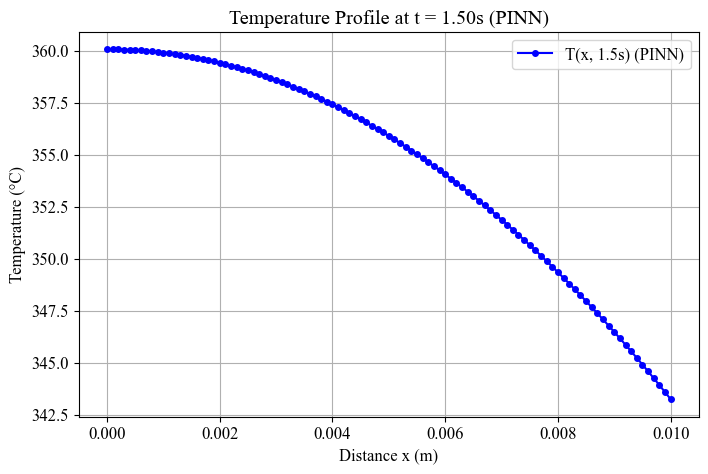

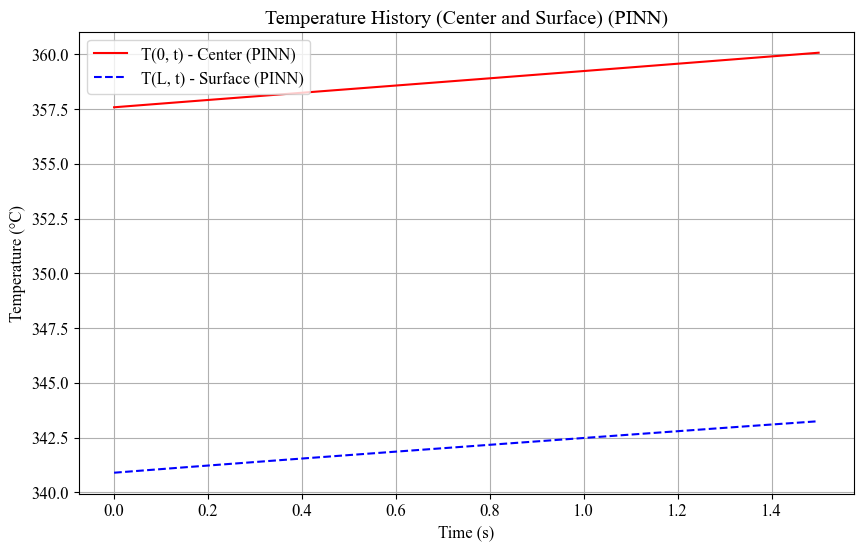

--- 绘图完成 ---


In [7]:
print("--- 正在绘制 (c) 问 PINN 结果图表 ---")

# 设置字体 (确保与 FDM 风格一致)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# 1. 准备绘图网格
N_plot = 101 # 绘图精度
x_plot = torch.linspace(0, L_DOMAIN, N_plot).view(-1, 1)
t_plot = torch.linspace(0, T_FINAL, N_plot).view(-1, 1)

# 2. 运行模型 (评估模式)
model.eval()
with torch.no_grad():
    # --- 图 1: T(x, 1.5s) 空间剖面图 ---
    t_final_tensor = torch.full_like(x_plot, T_FINAL).to(DEVICE)
    xt_test_spatial = torch.cat([x_plot.to(DEVICE), t_final_tensor], dim=1)
    T_pred_spatial = model(xt_test_spatial).cpu()
    
    # --- 图 2: T(0, t) 和 T(L, t) 时间历史图 ---
    x_zero_tensor = torch.zeros_like(t_plot).to(DEVICE)
    x_L_tensor = torch.full_like(t_plot, L_DOMAIN).to(DEVICE)
    
    xt_test_center = torch.cat([x_zero_tensor, t_plot.to(DEVICE)], dim=1)
    xt_test_surface = torch.cat([x_L_tensor, t_plot.to(DEVICE)], dim=1)
    
    T_pred_center = model(xt_test_center).cpu()
    T_pred_surface = model(xt_test_surface).cpu()

# 3. 绘制 T(x, 1.5s)
plt.figure(figsize=(8, 5))
plt.plot(x_plot.numpy(), T_pred_spatial.numpy(), 'b-o', markersize=4, label='T(x, 1.5s) (PINN)')
plt.xlabel('Distance x (m)')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Profile at t = {T_FINAL:.2f}s (PINN)')
plt.legend()
plt.grid(True)
plt.show()

# 4. 绘制 T(0, t) 和 T(L, t)
plt.figure(figsize=(10, 6))
plt.plot(t_plot.numpy(), T_pred_center.numpy(), 'r-', label='T(0, t) - Center (PINN)')
# (遵照你的要求，表面线改为蓝色虚线)
plt.plot(t_plot.numpy(), T_pred_surface.numpy(), 'b--', label='T(L, t) - Surface (PINN)') 
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature History (Center and Surface) (PINN)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

print("--- 绘图完成 ---")